<h1>Rock image Classification Model</h1>
<p>This project is a part of an evolving app designed to transition field data collection from a JFrame application running on a Toughbook to an Android or iPhone app. Geologists often collaborate with field technicians who assist in sampling and operations. In Alaska, these employees are disproportionately native Alaskans possessing valuable skills crucial for first-pass mineral exploration operations, although they generally lack geology-specific knowledge. Rock description plays a critical role in overcoming the geochemical limitations of rock classification. Without domain-specific knowledge in geology, producing an accurate classification of a rock is challenging.<br><br>Despite the difficulties, this project aims to make sampling more accessible to field technicians. Integrating an image classifier into the current data collection app is expected to enhance operational efficiency and increase work satisfaction among field technicians, who are often assigned more menial tasks than data collection.<br><br>The project focuses on using a dataset of common volcanic and metamorphic rocks found on the Tetlin Reservation, Palmer Project, Kensington Mine, and Turquoise Ridge Mine. These rocks are typically used to train geologists in first-pass exploration programs. The project's goal is to explore training of a convolutional multicategory image classifier using images of these hand samples.</p>

In [2]:
import sys
print(sys.version)
import tensorflow as tf
import os

3.8.18 | packaged by conda-forge | (default, Oct 10 2023, 15:46:01) 
[Clang 15.0.7 ]


2023-12-11 15:10:36.066659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h2>Data Scrape</h2>
<p>The literature suggests that a convolutional network for multicategory image classification should ideally have at least 1000 images for each class. Unfortunately, my dataset is considerably smaller. To address this limitation, I explored augmenting the dataset by incorporating images from Wikimedia Commons and, more significantly, valuable images obtained from mindat.com. The latter is more valuable primarily because the images depict the rock type in a rock sampling context.<br><br>In contrast, the images obtained from Wikimedia Commons lack the context specificity found in mindat and include pictures of mountains made of the rock, buildings constructed from the rock, as well as unrelated images like naked people with rocks or without, etc. The key takeaway is that, while a Wikimedia scrape yields thousands of images, many of them will be irrelevant to the primary function of this classifier, which is designed specifically to identify a hand sample. Further work is necessary to curate a more extensive dataset.</p>
<p>As these samples were collected primarily in Nevada and Alaska the classifier is trained almost exclusively on rock types exhibitting extensional and compressional fabrics.  As such it cannot be expected to perform well on undeformed images such as those that might present in interior of the country or newer rocks.  This is further constricting the use cases of the model, however, it is worth noting here as an inspiration to continue to build the image datasets in hopes that it will one day be large enough to generalize to more tectonic settings.</p>

<figure>
    <img src = "sampleLocs.png" alt="General Locations of Samples" style=text-align:center/>
    <figcaption style= text-align:center>A map showing the general locations of samples used in this classifier.  This region in general is highly deformed.</figcaption>
</figure>

In [3]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

def download_images(search_url, folder_path):
    response = requests.get(search_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        image_elements = soup.find_all('img', class_='thumbimage')
        image_urls = [urljoin(search_url, img['src']) for img in image_elements]
        os.makedirs(folder_path, exist_ok=True)
        for i, image_url in enumerate(image_urls, start=1):
            response = requests.get(image_url)
            image_filename = os.path.join(folder_path, f'diorite_image_{i}.jpg')
            with open(image_filename, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded: {image_filename}")
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")

search_url = "https://commons.wikimedia.org/w/index.php?search=diorite+rock&title=Special:MediaSearch&go=Go&type=image"
folder_path = "/Users/michaelspehlmann/Downloads"
download_images(search_url, folder_path)

<h2>Image Work</h2>
<p>In image classification there seems to be a general consensus that classifications that require fine attention to detail should use a larger lossless file format for training, testing, and predicting.  When compressing an image in a lossless file format no data is lost whereas a lossy compression is one in which image quality is allowed to decrease with compression.  Compression is an essential stage in building databases or even data pipelines.  While this project does not currently use an image database it perhaps should if it continues to scale and this is where it will probably be invaluable to use a lossless file format such as png.  As my images were primarily JPEG I included a script in the cell below that will convert all .jpegs to .png files.</p>

In [4]:
#convert to png b/c i like .png better as they have lossless compression
from PIL import Image

def convert_jpeg_to_png(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".jpg") or filename.lower().endswith(".jpeg"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + ".png")
            img = Image.open(input_path)
            img.save(output_path, "PNG")
            os.remove(input_path)

if __name__ == "__main__":
    input_folder = "/Users/michaelspehlmann/Downloads/gabbro"
    output_folder = "/Users/michaelspehlmann/Downloads/gabbro"
    convert_jpeg_to_png(input_folder, output_folder)

<h2>Image Work Continued</h2>
<p>Open Computer Vision is an opensource library of programs focused on computer vison.  The cell below serves two purposes: to remove non-image files from the dataset and checks the file encoding for consistency in the red, green, and blue color profiles.  This process returned some warnings related to the international color consortium profile that is an optional chunk of a png file.  There are several reasons for this warning but the all warrant human verification of the image to check that it is not corrupted.  Thankfully, there are not many of these warnings and all images appear to pass the human eye test for veracity that they are indeed what they are labelled as.  Evaluating the error further I think that the most likely reason for this error is that the International Color Consortium (ICC) profile is incorrect or missing in the image file or that the image was saved and manipulated in a way that the ICC profile does not reflect the actual image data.  At this stage after human verification of the warning images I am going to keep these files in the classifier dataset.  If I had a larger dataset I would have likely discarded them rather than try to understand the warning further, however, at this stage they will remain in the dataset.  Interestingly, all the images that produced the warnings originated from the webscrape.</p>

In [5]:
#image work image exts can just be .png but just leaving this in here in case this grows
import cv2
import imghdr

data_path = "/Users/michaelspehlmann/Documents/data/data"
img_exts = ["png", "jpeg", "jpg", "bmp"]

#no idea what .DS_Store files are so delete and make problems later
def delete_ds_store_files(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")
delete_ds_store_files(data_path)
bad_paths = []
#loop through all images
for cat in os.listdir(data_path):
    for img in os.listdir(os.path.join(data_path, cat)):
        img_path = os.path.join(data_path, cat, img)
        try:
            img = cv2.imread(img_path)
            #see path of your warnings bit janky and could use a fixing 
            bad_paths.append(img_path)
            tip = imghdr.what(img_path)
            if tip not in img_exts:
                    print("Not the correct image extension for this classifier, {}".format(img_path))
                    #DANGEROUS you could lose all your imgs
                    os.remove(img_path)
        except Exception as e:
             print("Big problem with image {}".format(img_path))
             #DANGEROUS you could lose all your imgs
             #os.remove(img_path)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [6]:
#data pipeline
import numpy as np
import matplotlib.pyplot as plt

data_dir = data_path

def is_image_file(filename):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    ext = os.path.splitext(filename)[1].lower()
    return ext in valid_extensions

image_files = [f for f in os.listdir(data_dir) if is_image_file(f)]

data = tf.keras.utils.image_dataset_from_directory(data_path, labels="inferred", label_mode="int", batch_size=32, image_size=(256, 256),
    shuffle=True, validation_split=0.2, subset="training", seed=42)

print("Class Names:", data.class_names)

for images, labels in data.take(1):
    print("Example Batch Shape:", images.shape)
    print("Example Batch Labels:", labels)

Found 149 files belonging to 8 classes.
Using 120 files for training.
Class Names: ['andesite', 'basalt', 'diorites', 'gabbro', 'gniess', 'granites', 'rhyolite', 'schist']


2023-12-11 15:10:43.798732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [120]
	 [[{{node Placeholder/_0}}]]
2023-12-11 15:10:43.799392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]
2023-12-11 15:10:43.964396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:44.006894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:44.029931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

Example Batch Shape: (32, 256, 256, 3)
Example Batch Labels: tf.Tensor([5 2 7 2 7 4 7 0 3 2 0 1 4 1 4 2 0 4 7 4 7 4 2 6 4 3 3 2 7 4 7 5], shape=(32,), dtype=int32)


2023-12-11 15:10:44.397086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:44.439714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2023-12-11 15:10:44.481880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [120]
	 [[{{node Placeholder/_0}}]]
2023-12-11 15:10:44.482323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]
2023-12-11 15:10:44.497645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:44.536954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:44.556710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

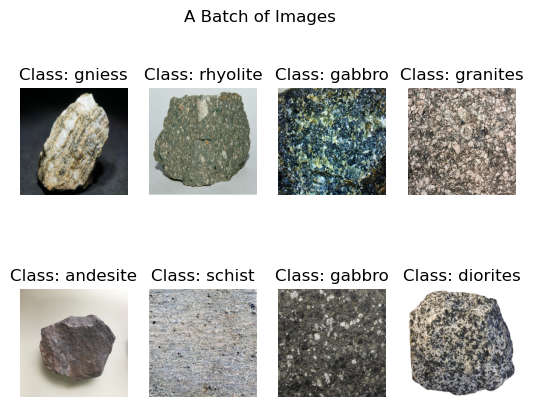

In [7]:
for images, labels in data.take(1): 
    
    num_images_to_display = 8
    for i in range(num_images_to_display):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {data.class_names[labels[i].numpy()]}")
        plt.axis("off")

    plt.suptitle("A Batch of Images")
    plt.show()

<h2>Preprocessing and Pipeline</h2>
<p>The preprocessing for these images is simple and could perhaps benefit from more rigorous image transformation techniques.  Rocks in general are usually quite drab so the effect of min max scaling is not all that apparent in the before and after scaled images.  The desired min max range is 0 to 1 pixel intensityin each red, green, blue channel instead of the 0 to 255 range found in those channels.  As the images are mostly at the extremes of the rgb values min max scaling brings them into a narrower range which can help the algorithm converge quicker at the modelling stage.</p>
<p>At first I was unsure if the color scaling actually worked as a visual check shows that the rocks look practically the same.  Then again I have never been a small details kind of geologist and am quite bad a rock identification myself so perhaps I am missing something.  I added a print line just to confirm that the pixels have the correct range of 0 to 1 which they do.  I imagine that because of the drab nature of most of these rocks it is unlikely that scaling has a significant visual effect.  When color variations are subtle then min max scaling does not visually appear to have a large effect.</p>
<p>Tensorflow uses a data pipeline which is an efficiency architecture for loading data model training, testing, or prediction.  The object has a large amount of functionality and can scale, augment, transform, and batch images.  I only used a small amount of this functionality, however, it might be beneficial and worth experimenting with the transforms and augmentations capabilities.  Right now the pipeline just assigns batch sizes, specifies the image size, and shuffles the data.  Shuffling is the default and means that images in the batch are randomized with each training run which helps prevent the model from training on the order that the images are in and instead train on attributes on the image.</p>

In [8]:
data = tf.keras.utils.image_dataset_from_directory(data_path, labels="inferred", label_mode="int", batch_size=8, image_size=(256, 256), shuffle=True,
    validation_split=0.2, subset="training", seed=42)

scaling_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)
scaled_data = data.map(lambda x, y: (scaling_layer(x), y))
train_size = int(0.8 * len(scaled_data))
test_size = len(scaled_data) - train_size

train_data = scaled_data.take(train_size)
test_data = scaled_data.skip(train_size)

scaled_iterator = scaled_data.as_numpy_iterator()
batch = scaled_iterator.next()
print("Batch min: {}, batch max: {}.\nStill cruiser! Just ignore the warning already looked into.".format(batch[0].min(), batch[0].max()))
scaled_data

class_names = data.class_names
print("Class names:", class_names)

Found 149 files belonging to 8 classes.
Using 120 files for training.


2023-12-11 15:10:45.252660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]
2023-12-11 15:10:45.252975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [120]
	 [[{{node Placeholder/_0}}]]
2023-12-11 15:10:45.275132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:45.312672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:45.331343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

Batch min: 0.0, batch max: 1.0.
Still cruiser! Just ignore the warning already looked into.
Class names: ['andesite', 'basalt', 'diorites', 'gabbro', 'gniess', 'granites', 'rhyolite', 'schist']


2023-12-11 15:10:45.680067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2023-12-11 15:10:45.724891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]
2023-12-11 15:10:45.725238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]
2023-12-11 15:10:45.732147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:45.759736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:45.804005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCC

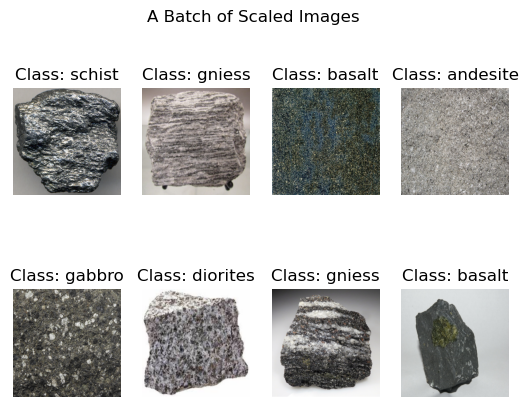

In [9]:
# Visualize the first 8 scaled images
for images, labels in scaled_data.take(1):
    num_images_to_display = 8
    for i in range(num_images_to_display):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Class: {data.class_names[labels[i].numpy()]}")
        plt.axis("off")
    plt.suptitle("A Batch of Scaled Images")
    plt.show()

<h2>Model Architecture</h2>
<p>I experimented with several different model architectures and different data sets.  The most significant model improvement was made simply by restricting the dataset to only images that were of hand samples which is sensible as this is designed to hopefully be an AI assistant that field workers will use to help collect geological data.  Therefore, by simply not including the Wikimedia Commons data with the non context specific images the model appears to have attained optimum performance with the current small dataset.  It is my hope that by curating or gaining access to a larger dataset, for example the rock types USGS or DGGS trains it's field geologist that this model's capabilities will continue to grow and lead to a model that can accurately identify all rock types instead of the just the eight most common rock types I have experience mapping.</p>
<p>I tried several different forward propagation model architectures and constistenly was able to achieve the best accuracy from a simpler model than I originally thought I needed.  The model heavily relies on pooling and convolution layers in the Keras api.  The Conv2D layer is designed to help recognize spatial hierarchies in images which makes them a natural choice for an image classification tasks.  There are several parameters that I experimented with but the parameter that I found to have best impact on accuracy without destroying convergence was adjusting the stride length paramter.  This parameter basically specifies how many pixels an image gets subdivided into and passed to other nodes.  A size of 3x3 seems optimal for this training.  Maxpooling2D layers were recommended in all the literature as both a variance reduction tool and as a way to decrease time to convergence.  This layer downsamples a 2x2 pixel area in the image and reclassifies the spaces as only the maximum value.  I initally had this set to 3x3 to match the Conv2D layer but then changed it for some reason and cannot remember why, however, the model works right now so when performance issues arise later I will look into this again.  All architectures I found included a dense layers after the convolution and pooling layers.  This necessitates a dimensionality reduction from the 2d arrays passed to the Conv2D and MaxPooling2D arrays to a flat array which is easily achieved using Flatten layer.<br><br>The last layers are Dense layers which in contrast to all the MaxPooling2D and Conv2D each node recieves all inputs from the Flatten layer.  In an effort to reduce overfitting I also included a Dropout layer after the Dense layer and before the final Dense output layer.  This layer accepts a rate parameter between 0 and 1 and depending on the rate will increase or decrease the frequency with which random elements in the flattened array are replaced with zeros.  This can help reduce overfitting which as I gather is a constant problem in fine detail image classification problems.  The output layer is another Dense layer with 8 nodes corresponding to the 8 different image classifications.  All activations were set to relu, or rectified linear unit functions with the exception of the final output layer.  Relu outputs the input if the input is positive otherwise it outputs zero.  Almost all architectures I looked at used relu exclusively for their Conv2D and MaxPooling2D layers so I just trusted that I should replicate it as well.  The final output layer necessitated using a softmax activation as this is a multicategory classifier.  This activation function can calculate the probability that the input is of a certain class.</p>

In [10]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [11]:
log_path = "/Volumes/ExtremeSSD/munDOX/app/field_app/classifier/logs"
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=log_path)
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=log_path)

model1 = models.Sequential([layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2 = models.Sequential([layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hx1 = model1.fit(train_data, epochs=15, validation_data=test_data, callbacks=[tensorboard_callback1])
hx2 = model2.fit(train_data, epochs=20, validation_data=test_data, callbacks=[tensorboard_callback2])

Epoch 1/15


2023-12-11 15:10:46.667694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]
2023-12-11 15:10:46.668032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]
2023-12-11 15:10:47.496355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:47.535332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:47.554482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCC

12/12 [==============================] - ETA: 0s - loss: 38.1143 - accuracy: 0.2708

2023-12-11 15:10:51.722030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [120]
	 [[{{node Placeholder/_0}}]]
2023-12-11 15:10:51.722363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]
2023-12-11 15:10:51.864706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:51.901819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:51.924512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

12/12 [==============================] - 6s 382ms/step - loss: 38.1143 - accuracy: 0.2708 - val_loss: 6.2889 - val_accuracy: 0.0833
Epoch 2/15


2023-12-11 15:10:52.611202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:52.653810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:52.671754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:53.016642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:53.071058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 27.9367 - accuracy: 0.4583

2023-12-11 15:10:56.720402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:56.758051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:56.777447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:57.120058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:57.167002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 369ms/step - loss: 27.9367 - accuracy: 0.4583 - val_loss: 7.5794 - val_accuracy: 0.0833
Epoch 3/15


2023-12-11 15:10:57.454040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:57.492734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:57.510742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:57.855328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:10:57.905250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 10.7094 - accuracy: 0.6562

2023-12-11 15:11:01.562217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:01.601918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:01.619990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:01.964718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:02.004461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 370ms/step - loss: 10.7094 - accuracy: 0.6562 - val_loss: 10.4049 - val_accuracy: 0.0417
Epoch 4/15


2023-12-11 15:11:02.301016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:02.342248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:02.360520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:02.699657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:02.752071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 7.3786 - accuracy: 0.6875

2023-12-11 15:11:06.384145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:06.426108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:06.446312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:06.784131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:06.825130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 367ms/step - loss: 7.3786 - accuracy: 0.6875 - val_loss: 13.1322 - val_accuracy: 0.0833
Epoch 5/15


2023-12-11 15:11:07.116216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:07.156644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:07.174593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:07.515309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:07.572683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 9.0305 - accuracy: 0.8021

2023-12-11 15:11:11.465450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:11.505946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:11.526354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:11.875375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:11.913466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 392ms/step - loss: 9.0305 - accuracy: 0.8021 - val_loss: 19.7290 - val_accuracy: 0.1250
Epoch 6/15


2023-12-11 15:11:12.212794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:12.258028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:12.279723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:12.632236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:12.682609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 4.2273 - accuracy: 0.7083

2023-12-11 15:11:16.319716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:16.360523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:16.380257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:16.717490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:16.765480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 368ms/step - loss: 4.2273 - accuracy: 0.7083 - val_loss: 19.1204 - val_accuracy: 0.2917
Epoch 7/15


2023-12-11 15:11:17.061618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:17.098979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:17.116635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:17.458400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:17.514730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 6.4515 - accuracy: 0.7917

2023-12-11 15:11:21.156968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:21.196443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:21.216041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:21.566554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:21.603409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 369ms/step - loss: 6.4515 - accuracy: 0.7917 - val_loss: 22.5059 - val_accuracy: 0.2500
Epoch 8/15


2023-12-11 15:11:21.891849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:21.930956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:21.948573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:22.294041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:22.354101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 4.2406 - accuracy: 0.8750

2023-12-11 15:11:26.070009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:26.109610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:26.131104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:26.481717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:26.520501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 375ms/step - loss: 4.2406 - accuracy: 0.8750 - val_loss: 25.4980 - val_accuracy: 0.1667
Epoch 9/15


2023-12-11 15:11:26.817524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:26.854857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:26.873243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:27.220319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:27.272037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 1.3246 - accuracy: 0.8958

2023-12-11 15:11:30.952072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:30.990811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:31.015138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:31.361962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:31.404254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 373ms/step - loss: 1.3246 - accuracy: 0.8958 - val_loss: 35.9742 - val_accuracy: 0.2083
Epoch 10/15


2023-12-11 15:11:31.702039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:31.741092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:31.759044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:32.102183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:32.178640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 1.4684 - accuracy: 0.9375

2023-12-11 15:11:35.804737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:35.840135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:35.858023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:36.205531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:36.243766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 369ms/step - loss: 1.4684 - accuracy: 0.9375 - val_loss: 45.7397 - val_accuracy: 0.2083
Epoch 11/15


2023-12-11 15:11:36.541143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:36.583286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:36.602516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:36.951747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:37.009369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 1.3037 - accuracy: 0.9375

2023-12-11 15:11:40.620853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:40.660723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:40.681066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:41.029052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:41.066843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 368ms/step - loss: 1.3037 - accuracy: 0.9375 - val_loss: 64.0503 - val_accuracy: 0.3750
Epoch 12/15


2023-12-11 15:11:41.368319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:41.410309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:41.428403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:41.773975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:41.846329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 2.4530 - accuracy: 0.9271

2023-12-11 15:11:45.588583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:45.631825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:45.649611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:46.000742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:46.041441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 381ms/step - loss: 2.4530 - accuracy: 0.9271 - val_loss: 48.4603 - val_accuracy: 0.2917
Epoch 13/15


2023-12-11 15:11:46.334214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:46.377033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:46.398914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:46.744613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:46.815615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.8231 - accuracy: 0.9583

2023-12-11 15:11:50.462933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:50.505031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:50.529368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:50.876094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:50.919417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 372ms/step - loss: 0.8231 - accuracy: 0.9583 - val_loss: 82.4783 - val_accuracy: 0.1250
Epoch 14/15


2023-12-11 15:11:51.219142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:51.259314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:51.277305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:51.627064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:51.709272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 1.4340 - accuracy: 0.9271

2023-12-11 15:11:55.312309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:55.351660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:55.370155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:55.715047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:55.757718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 368ms/step - loss: 1.4340 - accuracy: 0.9271 - val_loss: 71.5495 - val_accuracy: 0.2083
Epoch 15/15


2023-12-11 15:11:56.053916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:56.093256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:56.111720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:56.457870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:11:56.530779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 1.4140e-05 - accuracy: 1.0000

2023-12-11 15:12:00.167310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:00.207351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:00.224942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:00.569876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:00.619132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 373ms/step - loss: 1.4140e-05 - accuracy: 1.0000 - val_loss: 75.3609 - val_accuracy: 0.2917
Epoch 1/20


2023-12-11 15:12:01.483099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:01.521390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:01.539243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:01.884883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:01.952754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 3.2616 - accuracy: 0.0938

2023-12-11 15:12:05.719697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:05.759906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:05.778421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:06.130789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:06.171702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 6s 380ms/step - loss: 3.2616 - accuracy: 0.0938 - val_loss: 2.0664 - val_accuracy: 0.1667
Epoch 2/20


2023-12-11 15:12:06.471494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:06.510589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:06.531345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:06.884467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:06.954928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 2.0858 - accuracy: 0.1354

2023-12-11 15:12:10.698133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:10.741931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:10.761026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:11.108291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:11.162967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 384ms/step - loss: 2.0858 - accuracy: 0.1354 - val_loss: 2.0391 - val_accuracy: 0.2083
Epoch 3/20


2023-12-11 15:12:11.471516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:11.511298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:11.532507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:11.882655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:11.953672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 2.0666 - accuracy: 0.1979

2023-12-11 15:12:15.522197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:15.556623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:15.575083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:15.919925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:15.957444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 363ms/step - loss: 2.0666 - accuracy: 0.1979 - val_loss: 2.0299 - val_accuracy: 0.2083
Epoch 4/20


2023-12-11 15:12:16.265630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:16.310618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:16.333953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:16.692326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:16.771864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 2.0540 - accuracy: 0.2083

2023-12-11 15:12:20.286376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:20.326251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:20.344194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:20.697357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:20.735856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 360ms/step - loss: 2.0540 - accuracy: 0.2083 - val_loss: 1.7806 - val_accuracy: 0.5417
Epoch 5/20


2023-12-11 15:12:21.039956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:21.080673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:21.098282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:21.447780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:21.528271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 1.9634 - accuracy: 0.2812

2023-12-11 15:12:25.034323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:25.073471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:25.091465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:25.440413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:25.482619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 360ms/step - loss: 1.9634 - accuracy: 0.2812 - val_loss: 1.9128 - val_accuracy: 0.3333
Epoch 6/20


2023-12-11 15:12:25.784798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:25.826570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:25.846993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:26.194303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:26.277766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 1.7529 - accuracy: 0.3958

2023-12-11 15:12:29.737621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:29.778141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:29.795913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:30.147471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:30.184930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 357ms/step - loss: 1.7529 - accuracy: 0.3958 - val_loss: 1.5840 - val_accuracy: 0.3333
Epoch 7/20


2023-12-11 15:12:30.481999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:30.525625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:30.540841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:30.888983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:30.970099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 1.5622 - accuracy: 0.4792

2023-12-11 15:12:34.465865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:34.503874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:34.521953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:34.869701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:34.913558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 355ms/step - loss: 1.5622 - accuracy: 0.4792 - val_loss: 1.1223 - val_accuracy: 0.7917
Epoch 8/20


2023-12-11 15:12:35.198279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:35.240378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:35.258443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:35.603287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:35.664148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 1.3771 - accuracy: 0.5729

2023-12-11 15:12:39.129503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:39.174103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:39.208406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:39.562855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:39.606472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 360ms/step - loss: 1.3771 - accuracy: 0.5729 - val_loss: 1.0295 - val_accuracy: 0.8750
Epoch 9/20


2023-12-11 15:12:39.928920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:39.973634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:39.992066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:40.347085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:40.431949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.7292

2023-12-11 15:12:43.983371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:44.027412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:44.042523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:44.391351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:44.433335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 364ms/step - loss: 1.0382 - accuracy: 0.7292 - val_loss: 0.8628 - val_accuracy: 0.8750
Epoch 10/20


2023-12-11 15:12:44.726901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:44.767817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:44.788101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:45.134200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:45.217735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.8676 - accuracy: 0.7917

2023-12-11 15:12:48.655619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:48.696235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:48.713891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:49.059087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:49.103517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 356ms/step - loss: 0.8676 - accuracy: 0.7917 - val_loss: 0.6264 - val_accuracy: 0.9167
Epoch 11/20


2023-12-11 15:12:49.397740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:49.439097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:49.459993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:49.806185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:49.878215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.8125

2023-12-11 15:12:53.334439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:53.371623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:53.389546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:53.738479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:53.774892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 354ms/step - loss: 0.7449 - accuracy: 0.8125 - val_loss: 0.2735 - val_accuracy: 0.9583
Epoch 12/20


2023-12-11 15:12:54.064141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:54.104821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:54.122341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:54.467112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:54.546333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.8438

2023-12-11 15:12:57.946339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:57.986888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:58.004858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:58.352625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:58.394160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 352ms/step - loss: 0.5901 - accuracy: 0.8438 - val_loss: 0.2958 - val_accuracy: 0.9583
Epoch 13/20


2023-12-11 15:12:58.689337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:58.734765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:58.752880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:59.096887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:12:59.164396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.8646

2023-12-11 15:13:02.581103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:02.622899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:02.642773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:02.986534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:03.029044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 352ms/step - loss: 0.5753 - accuracy: 0.8646 - val_loss: 0.3903 - val_accuracy: 0.7917
Epoch 14/20


2023-12-11 15:13:03.325872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:03.370055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:03.390648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:03.736307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:03.811202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.8958

2023-12-11 15:13:07.225802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:07.267259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:07.287912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:07.637038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:07.678247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 352ms/step - loss: 0.3570 - accuracy: 0.8958 - val_loss: 0.1998 - val_accuracy: 1.0000
Epoch 15/20


2023-12-11 15:13:07.965386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:08.008347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:08.026893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:08.377072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:08.446581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.9479

2023-12-11 15:13:11.860175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:11.899667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:11.917217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:12.268475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:12.312689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 351ms/step - loss: 0.3105 - accuracy: 0.9479 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 16/20


2023-12-11 15:13:12.598693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:12.640563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:12.658640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:13.001505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:13.064156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9167

2023-12-11 15:13:16.509038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:16.545958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:16.564055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:16.910768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:16.948970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 353ms/step - loss: 0.1900 - accuracy: 0.9167 - val_loss: 0.1223 - val_accuracy: 1.0000
Epoch 17/20


2023-12-11 15:13:17.234112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:17.276445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:17.298102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:17.639535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:17.698053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9583

2023-12-11 15:13:21.149126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:21.192343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:21.211674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:21.553909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:21.605931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 354ms/step - loss: 0.1961 - accuracy: 0.9583 - val_loss: 0.0886 - val_accuracy: 1.0000
Epoch 18/20


2023-12-11 15:13:21.890326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:21.928145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:21.946121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:22.290075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:22.369917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9688

2023-12-11 15:13:25.787213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:25.828854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:25.846898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:26.190073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:26.232170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 352ms/step - loss: 0.1412 - accuracy: 0.9688 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 19/20


2023-12-11 15:13:26.516000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:26.553452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:26.570847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:26.921830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:26.992463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9792

2023-12-11 15:13:30.412058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:30.452338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:30.469843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:30.816116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:30.861854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 351ms/step - loss: 0.1634 - accuracy: 0.9792 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 20/20


2023-12-11 15:13:31.144085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:31.186765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:31.207816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:31.557007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:31.640159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9792

2023-12-11 15:13:35.059865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:35.101766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:35.119648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:35.466088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-11 15:13:35.505086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 5s 352ms/step - loss: 0.1720 - accuracy: 0.9792 - val_loss: 0.0145 - val_accuracy: 1.0000


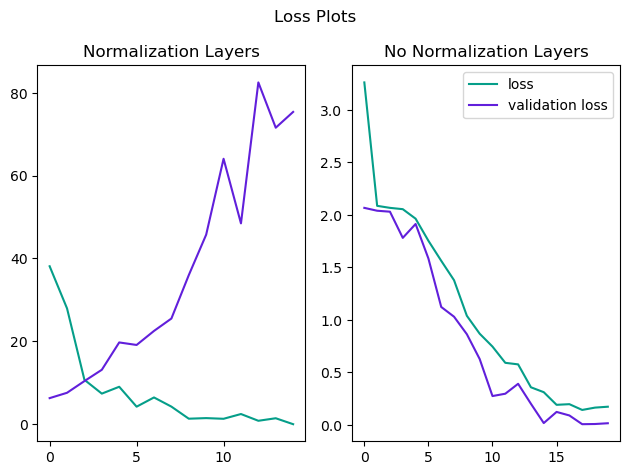

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(hx1.history["loss"], color="#059e89", label="loss")
ax1.plot(hx1.history["val_loss"], color="#611fdb", label="validation loss")
ax1.set_title("Normalization Layers")

ax2.plot(hx2.history["loss"], color="#059e89", label="loss")
ax2.plot(hx2.history["val_loss"], color="#611fdb", label="validation loss")
ax2.legend(loc="upper right")
ax2.set_title("No Normalization Layers")

fig.suptitle("Loss Plots")
fig.tight_layout()

<h2>Training On Model 2</h2>
<h3>Good indicators</h3>
<ul>
    <li>Loss on the training data goes down consistently</li>
    <li>Accuracy on the training data goes up consistently</li>
    <li>Validation loss goes consistently decreasing </li>
    <li>Validation accuracy goes up consistently</li>
</ul>
<h3>Bad indicators</h3>
<ul>
    <li>Validation accuracy approaches 1 and reaches 1</li>
        <ul>
            <li>Added a dropout layer after the dense layer which reduced how many epochs reached validation accuracy of 1</li>
            <li>Perhaps further experimentation with regularization rate in this layer is warranted</li>
        </ul>
    <ul>
        <li>Possible over fit or training and validation sets do not equally represent classes</li>
    </ul>
    <li>Ignore sRGB profile warning this was addressed in quality control step earlier</li>
    <ul>
        <li>For some reason Tensorflow likes to tell you</li>
    </ul>
</ul>

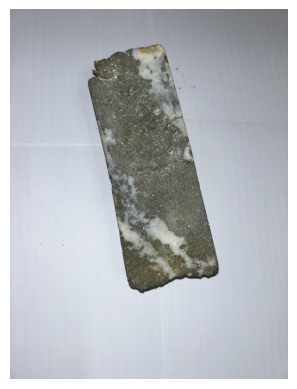

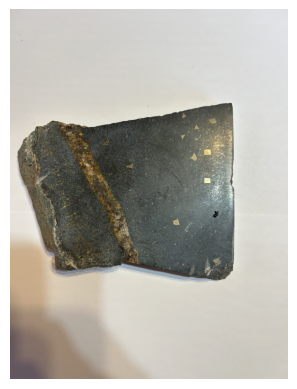

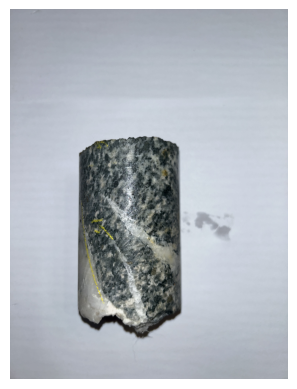

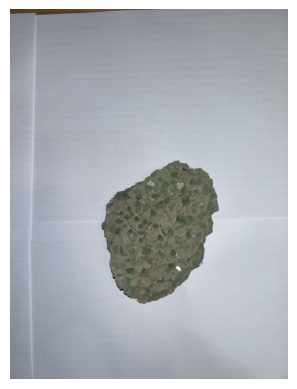

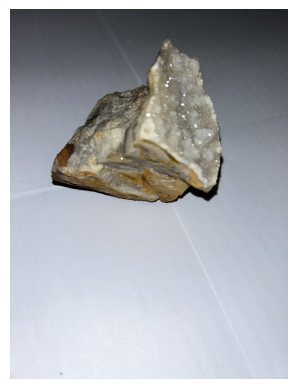

In [13]:
#Test on some rocks in my trunk
new_img1 = cv2.imread(r"/Users/michaelspehlmann/Documents/data/test/IMG_9930.png")
new_img2 = cv2.imread(r"/Users/michaelspehlmann/Documents/data/test/IMG_9944.png")
new_img3 = cv2.imread(r"/Users/michaelspehlmann/Documents/data/test/IMG_9946.png")
new_img4 = cv2.imread(r"/Users/michaelspehlmann/Documents/data/test/IMG_9950.png")
new_img5 = cv2.imread(r"/Users/michaelspehlmann/Documents/data/test/IMG_9924.png")


for img in [new_img1, new_img2, new_img3, new_img4, new_img5]:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

new_img5 = tf.image.resize(new_img5, (256,256))
new_img4 = tf.image.resize(new_img4, (256,256))
new_img3 = tf.image.resize(new_img3, (256,256))
new_img2 = tf.image.resize(new_img2, (256,256))
new_img1 = tf.image.resize(new_img1, (256,256))

In [14]:
#where did I put those class labels?
class_names = data.class_names
print("Class names:", class_names)
y_hat2 = model2.predict(np.expand_dims(new_img2/255, 0))
y_hat3 = model2.predict(np.expand_dims(new_img3/255, 0))

y_hat3 = np.array(y_hat3)
y_hat3_flattened = y_hat3.flatten()
y_hat3_idx = np.argmax(y_hat3_flattened)
print(y_hat3_flattened)
print("Index of the element with the highest value:", y_hat3_idx)
print("The rock classification for image 2 is {}.".format(class_names[y_hat3_idx]))
print("The actual description in the log is a diorite.")


y_hat2_flattened = y_hat2.flatten()
y_hat2_idx = np.argmax(y_hat2_flattened)
print(y_hat2_flattened)
print("Index of the element with the highest value:", y_hat2_idx)
print("The rock classification for image 3 is {}.".format(class_names[y_hat2_idx]))
print("The actual is a pillow basalt so it's a basalt.")

Class names: ['andesite', 'basalt', 'diorites', 'gabbro', 'gniess', 'granites', 'rhyolite', 'schist']
1/1 [==============================] - 0s 33ms/step
[0.00452395 0.24000494 0.30546755 0.12260478 0.00140768 0.13143514
 0.00036582 0.19419014]
Index of the element with the highest value: 2
The rock classification for image 2 is diorites.
[5.3591933e-04 6.3711470e-01 1.3221753e-01 8.4566051e-04 8.1472650e-02
 1.2587522e-01 8.7475998e-04 2.1063570e-02]
Index of the element with the highest value: 1
The rock classification for image 3 is basalt.


In [15]:
from tensorflow.keras.models import load_model
#model2.save(os.path.join("/Volumes/ExtremeSSD/munDOX/app/field_app/classifier/models", "rockClass.h5"))

<h2>Testing</h2>
<p>This test is not exhaustive. Before integration into the field application, it requires more rigorous testing, along with an improved training set. I am genuinely surprised that it accurately classified the core sample, considering the training set lacks core samples. I initially thought the presence of quartz veins might complicate this classification. The basalt slab is a sample I could easily identify. Therefore, I would assert that, at this point, the model is as proficient at identifying rocks as I am. The other rock images were not classified by the model, as I am confident they do not belong to any of the rock types the network was trained on. Nonetheless, they serve as inspiration for future enhancements to this model.</p>
<h2>Conclusions</h2>
<p>This project is a continual work in progress, intended to serve as an AI assistant for a field application utilized by field crews. Currently, the application is an outdated JFrame program running on a Toughbook from the early 2010s, which, surprisingly, remains the backbone of exploration programs. My aspiration is that, with a meticulously curated dataset comprising thousands of images for each classification, this model will evolve into an invaluable asset. The plan involves transforming the application into a mobile app compatible with Android or iPhone, featuring an AI assistant to aid in rock type classification during the data collection phase. Successful implementation of this model has the potential to significantly enhance the quality control of field data. Furthermore, I believe that, when applied correctly, AI can have a profound equalizing effect between those who possess certain knowledge and those who do not. For instance, if the model can accurately classify rock types, it may render the traditional approach of relying solely on a college-educated geologist for chipping outcrop samples for chemical or thin section analysis unnecessary. Instead the field sampling aspect of a program could be effectively executed with field helpers, who are traditionally confined to more labor-intensive support roles.</p>
